#**Task 2 of Mini Project: Text Classification using Deep Learning**

##**1. Data Loading**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_legal_dataset.csv to synthetic_legal_dataset (1).csv


In [ ]:
data = pd.read_csv('/content/synthetic_legal_dataset.csv')
data.head()

,case_document,class
0,Probate Court Proceeding Case No. 2476-CV-2023...,family
1,Case No. 1576-F-2017. Property Owner v. Driver...,civil
2,Case No. 9190-CR-2011. Civil action between Em...,civil
3,"Case No. 9046-C-2015, Child v. State Departmen...",family
4,"Family Case Case No. 8948-A-2024, Juvenile Cou...",family


Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   case_document  2000 non-null   object
 1   class          2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None

Sample data:
                                       case_document   class
0  Probate Court Proceeding Case No. 2476-CV-2023...  family
1  Case No. 1576-F-2017. Property Owner v. Driver...   civil
2  Case No. 9190-CR-2011. Civil action between Em...   civil
3  Case No. 9046-C-2015, Child v. State Departmen...  family
4  Family Case Case No. 8948-A-2024, Juvenile Cou...  family


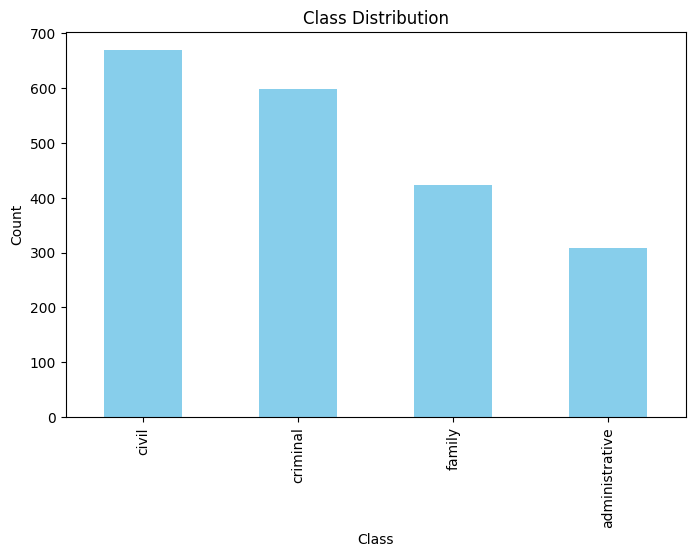

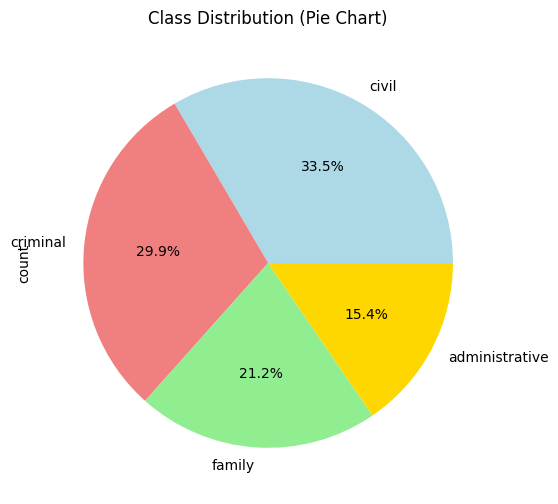

Count of unknown labels: 0


In [ ]:
print("Dataset overview:")
print(data.info())
print("\nSample data:")
print(data.head())

plt.figure(figsize=(8, 5))
data['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("\n")

plt.figure(figsize=(6, 6))
data['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Class Distribution (Pie Chart)')
# plt.ylabel('')  # Hide y-label for better visualization
plt.show()

unknown_count = (data['class'] == 'unknown').sum()
print(f"Count of unknown labels: {unknown_count}")

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

##**2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

train_data['processed_text'] = train_data['case_document'].apply(preprocess_text)
val_data['processed_text'] = val_data['case_document'].apply(preprocess_text)
test_data['processed_text'] = test_data['case_document'].apply(preprocess_text)

train_data[[ 'processed_text']].head()

,processed_text
1663,family case case 6692 b 2016 circuit court fam...
1048,criminal prosecution case 3750 cr 2011 heard c...
1504,civil case case 1840 2021 heard philadelphia n...
132,administrative review case 9255 f 2020 departm...
1416,case 3003 f 2012 civil action company client c...


##**3. Text Embedding**

In [ ]:
# pip install gensim

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()


tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")
print(X_train_bow)
print(X_train_tfidf)
# print(X_train_fasttext)

Embedding completed for BoW, TF-IDF, and FastText.
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0.         0.         0.         ... 0.18945413 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.12175228 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.10975843 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


##**4. Training with different architectures**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

In [ ]:
# CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['class'])
val_labels = label_encoder.transform(val_data['class'])
test_labels = label_encoder.transform(test_data['class'])

A) With BOW Embeddings

In [ ]:
input_dim_bow = X_train_bow.shape[1]
#CNN
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#lstm
lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#bilstm
bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

#cnn_bilstm
cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

Training CNN with BoW...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 811ms/step - accuracy: 0.4756 - loss: 1.2043 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 753ms/step - accuracy: 1.0000 - loss: 2.6912e-04 - val_accuracy: 1.0000 - val_loss: 1.5385e-06
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 801ms/step - accuracy: 1.0000 - loss: 4.5549e-07 - val_accuracy: 1.0000 - val_loss: 4.5746e-07
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 762ms/step - accuracy: 1.0000 - loss: 3.5300e-07 - val_accuracy: 1.0000 - val_loss: 3.3155e-07
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 818ms/step - accuracy: 1.0000 - loss: 1.7286e-07 - val_accuracy: 1.0000 - val_loss: 2.7642e-07
Training LSTM with BoW...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3299 - loss: 1.3519 - val_accuracy: 0.3250 - val_loss: 1.3473
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.3519 - loss: 1.3462 - val_accuracy: 0.3438 - val_loss: 1.3166
Epoch 3/5
23/23 ━━━━━━━━━

B) With TFIDF

In [ ]:
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

Training CNN with TF-IDF...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.2820 - loss: 1.3903 - val_accuracy: 0.3187 - val_loss: 1.3606
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 867ms/step - accuracy: 0.3404 - loss: 1.3611 - val_accuracy: 0.3187 - val_loss: 1.3803
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 828ms/step - accuracy: 0.3438 - loss: 1.3746 - val_accuracy: 0.2000 - val_loss: 1.3860
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 863ms/step - accuracy: 0.3209 - loss: 1.3658 - val_accuracy: 0.3187 - val_loss: 1.3681
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 804ms/step - accuracy: 0.3422 - loss: 1.3639 - val_accuracy: 0.3187 - val_loss: 1.3613
Training LSTM with TF-IDF...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.2916 - loss: 1.3603 - val_accuracy: 0.3187 - val_loss: 1.3530
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.3425 - loss: 1.3503 - val_accuracy: 0.3187 - val_loss: 1.3487
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step -

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = 100
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#  CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['class'].unique()), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7532 - loss: 0.7417 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9985 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 3.8546e-04
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 5.4735e-04 - val_accuracy: 1.0000 - val_loss: 2.2207e-04
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 2.8245e-04 - val_accuracy: 1.0000 - val_loss: 1.6848e-04
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 2.3436e-04 - val_accuracy: 1.0000 - val_loss: 1.6807e-04
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.3219 - loss: 1.3534 - val_accuracy: 0.4812 - val_loss: 1.0303
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.5201 - loss: 0.9900 - val_accuracy: 0.5125 - val_loss: 0.9151
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.5256 - loss: 0.8865 - val_accuracy: 0.6375 - val_loss: 0.7476
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.6191 - loss: 0.7792 - val_accuracy: 0.6375 - val_loss: 0.7353
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.6193 - loss: 0.8568 - val_accuracy: 0.6375 - val_loss: 0.8111
Training BiLSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 412ms/step - accuracy: 0.5228 - loss: 1.1199 - val_accuracy: 0.8375 - val_loss: 0.2876
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - accuracy: 0.8913 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 0.0907
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.9542 - loss: 0.1467 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.9920 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.9949 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0057
Training CNN-BiLSTM with FastText...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 332ms/step - accuracy: 0.4810 - loss: 1.1416 - val_accuracy: 0.8375 - val_loss: 0.2614
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9056 - loss: 0.2109 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9837 - loss: 0

##**5. Comparing Different Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = accuracy_score(test_labels, y_pred)
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Dictionary to store models and their corresponding test sets
models = {
    "BoW": {
        "CNN": cnn_bow,
        "LSTM": lstm_bow,
        "BiLSTM": bilstm_bow,
        "CNN-BiLSTM": cnn_bilstm_bow,
        "X_test": X_test_bow
    },
    "TF-IDF": {
        "CNN": cnn_tfidf,
        "LSTM": lstm_tfidf,
        "BiLSTM": bilstm_tfidf,
        "CNN-BiLSTM": cnn_bilstm_tfidf,
        "X_test": X_test_tfidf
    },
    "FastText": {
        "CNN": cnn_fasttext,
        "LSTM": lstm_fasttext,
        "BiLSTM": bilstm_fasttext,
        "CNN-BiLSTM": cnn_bilstm_fasttext,
        "X_test": X_test_fasttext_padded
    }
}

# Loop through each feature type and evaluate models
for feature, model_dict in models.items():
    print(f"\nEvaluating {feature}-based models...")
    X_test = model_dict.pop("X_test")  # Extract test data
    for model_name, model in model_dict.items():
        acc = evaluate_model(model, X_test, test_labels, f"{model_name} with {feature}")



Evaluating BoW-based models...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
CNN with BoW Accuracy: 1.0000
CNN with BoW Classification Report:
                precision    recall  f1-score   support

administrative       1.00      1.00      1.00        62
         civil       1.00      1.00      1.00       138
      criminal       1.00      1.00      1.00       118
        family       1.00      1.00      1.00        82

      accuracy                           1.00       400
     macro avg       1.00      1.00      1.00       400
  weighted avg       1.00      1.00      1.00       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 596ms/step
LSTM with BoW Accuracy: 0.5725
LSTM with BoW Classification Report:
                precision    recall  f1-score   support

administrative       0.52      0.35      0.42        62
         civil       0.55      0.78      0.65       138
      criminal       0.60      0.69      0.64       118
        family       0.65      0.21      0.31        82

      accuracy      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with TF-IDF Accuracy: 0.3450
LSTM with TF-IDF Classification Report:
                precision    recall  f1-score   support

administrative       0.00      0.00      0.00        62
         civil       0.34      1.00      0.51       138
      criminal       0.00      0.00      0.00       118
        family       0.00      0.00      0.00        82

      accuracy                           0.34       400
     macro avg       0.09      0.25      0.13       400
  weighted avg       0.12      0.34      0.18       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiLSTM with TF-IDF Accuracy: 0.3450
BiLSTM with TF-IDF Classification Report:
                precision    recall  f1-score   support

administrative       0.00      0.00      0.00        62
         civil       0.34      1.00      0.51       138
      criminal       0.00      0.00      0.00       118
        family       0.00      0.00      0.00        82

      accuracy                           0.34       400
     macro avg       0.09      0.25      0.13       400
  weighted avg       0.12      0.34      0.18       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 594ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.3450
CNN-BiLSTM with TF-IDF Classification Report:
                precision    recall  f1-score   support

administrative       0.00      0.00      0.00        62
         civil       0.34      1.00      0.51       138
      criminal       0.00      0.00      0.00       118
        family       0.00      0.00      0.00        82

      accuracy                           0.34       400
     m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN with FastText Accuracy: 1.0000
CNN with FastText Classification Report:
                precision    recall  f1-score   support

administrative       1.00      1.00      1.00        62
         civil       1.00      1.00      1.00       138
      criminal       1.00      1.00      1.00       118
        family       1.00      1.00      1.00        82

      accuracy                           1.00       400
     macro avg       1.00      1.00      1.00       400
  weighted avg       1.00      1.00      1.00       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
LSTM with FastText Accuracy: 0.6375
LSTM with FastText Classification Report:
                precision    recall  f1-score   support

administrative       0.00      0.00      0.00        62
         civil       0.99      1.00      1.00       138
      criminal       0.45      0.99      0.62       118
        family       0.00      0.00      0.00        82

      accuracy                           0.64       400
     macro avg   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
BiLSTM with FastText Accuracy: 1.0000
BiLSTM with FastText Classification Report:
                precision    recall  f1-score   support

administrative       1.00      1.00      1.00        62
         civil       1.00      1.00      1.00       138
      criminal       1.00      1.00      1.00       118
        family       1.00      1.00      1.00        82

      accuracy                           1.00       400
     macro avg       1.00      1.00      1.00       400
  weighted avg       1.00      1.00      1.00       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
CNN-BiLSTM with FastText Accuracy: 1.0000
CNN-BiLSTM with FastText Classification Report:
                precision    recall  f1-score   support

administrative       1.00      1.00      1.00        62
         civil       1.00      1.00      1.00       138
      criminal       1.00      1.00      1.00       118
        family       1.00      1.00      1.00        82

      accuracy 

In [ ]:
import pandas as pd

data = [
    {"No.": 1, "Model Name": "CNN", "Feature": "BoW", "Precision": 1.00, "Recall": 1.00, "F1 Score": 1.00, "Accuracy": 1.0000},
    {"No.": 2, "Model Name": "LSTM", "Feature": "BoW", "Precision": 0.58, "Recall": 0.57, "F1 Score": 0.54, "Accuracy": 0.5725},
    {"No.": 3, "Model Name": "BiLSTM", "Feature": "BoW", "Precision": 0.75, "Recall": 0.75, "F1 Score": 0.74, "Accuracy": 0.7500},
    {"No.": 4, "Model Name": "CNN-BiLSTM", "Feature": "BoW", "Precision": 0.88, "Recall": 0.87, "F1 Score": 0.87, "Accuracy": 0.8725},

    {"No.": 5, "Model Name": "CNN", "Feature": "TF-IDF", "Precision": 0.12, "Recall": 0.34, "F1 Score": 0.18, "Accuracy": 0.3450},
    {"No.": 6, "Model Name": "LSTM", "Feature": "TF-IDF", "Precision": 0.12, "Recall": 0.34, "F1 Score": 0.18, "Accuracy": 0.3450},
    {"No.": 7, "Model Name": "BiLSTM", "Feature": "TF-IDF", "Precision": 0.12, "Recall": 0.34, "F1 Score": 0.18, "Accuracy": 0.3450},
    {"No.": 8, "Model Name": "CNN-BiLSTM", "Feature": "TF-IDF", "Precision": 0.12, "Recall": 0.34, "F1 Score": 0.18, "Accuracy": 0.3450},

    {"No.": 9, "Model Name": "CNN", "Feature": "FastText", "Precision": 1.00, "Recall": 1.00, "F1 Score": 1.00, "Accuracy": 1.0000},
    {"No.": 10, "Model Name": "LSTM", "Feature": "FastText", "Precision": 0.47, "Recall": 0.64, "F1 Score": 0.53, "Accuracy": 0.6375},
    {"No.": 11, "Model Name": "BiLSTM", "Feature": "FastText", "Precision": 1.00, "Recall": 1.00, "F1 Score": 1.00, "Accuracy": 1.0000},
    {"No.": 12, "Model Name": "CNN-BiLSTM", "Feature": "FastText", "Precision": 1.00, "Recall": 1.00, "F1 Score": 1.00, "Accuracy": 1.0000},
]

df = pd.DataFrame(data)
df

,No.,Model Name,Feature,Precision,Recall,F1 Score,Accuracy
0,1,CNN,BoW,1.00,1.00,1.00,1.0000
1,2,LSTM,BoW,0.58,0.57,0.54,0.5725
2,3,BiLSTM,BoW,0.75,0.75,0.74,0.7500
3,4,CNN-BiLSTM,BoW,0.88,0.87,0.87,0.8725
4,5,CNN,TF-IDF,0.12,0.34,0.18,0.3450
5,6,LSTM,TF-IDF,0.12,0.34,0.18,0.3450
6,7,BiLSTM,TF-IDF,0.12,0.34,0.18,0.3450
7,8,CNN-BiLSTM,TF-IDF,0.12,0.34,0.18,0.3450
8,9,CNN,FastText,1.00,1.00,1.00,1.0000
9,10,LSTM,FastText,0.47,0.64,0.53,0.6375


##**6. Selecting the Best Model**

In [ ]:
cnn_bow.save('best_model.h5')
print("Best model saved successfully")

Best model saved successfully


##**7. Predict on real world input**

In [ ]:
from keras.models import load_model
model = load_model('best_model.h5')

new_text = "The accused was arrested for burglary in a residential area. Witnesses reported seeing the accused breaking into a house at midnight and stealing valuables. Upon investigation, the police recovered stolen items from the accused’s possession. The prosecution argues that there is sufficient evidence to convict the accused under sections related to theft and unlawful entry"

processed_text = preprocess_text(new_text)

input_data = bow_vectorizer.transform([processed_text]).toarray()

predicted_class = model.predict(input_data)

predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Class: criminal
